In [1]:
import requests
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# From https://stackoverflow.com/questions/50786266/writing-dictionary-of-dataframes-to-file
import csv
import pandas as pd

def save_dict_df(dictex, keys_filename="stock_keys.txt", data_folder="hourly_stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="stock_keys.txt", data_folder="hourly_stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [3]:
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']
stock_columns = ['open', 'high', 'low', 'close', 'volume']

In [4]:
#create kw_list 
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [5]:
# Get 3-month ago trend data. May need to run a couple times to make sure it doesn't time out. 
def getTrendDataDF(kw_list, pull_data=False, dates='today 3-m', pytrends_df_filename="hourly_pytrends.csv"):
    # Retrieve the cached trend data
    if not pull_data and os.path.isfile(pytrends_df_filename):
        df = pd.read_csv(pytrends_df_filename, index_col="date")
        
    else: # Construct the dataframe by making pytrends calls
        df = pd.DataFrame()
        data = {}
        #print(df.empty)
        pytrends = TrendReq(hl='en-US', tz=360)
        sleep = True
        for kw in kw_list:
            if 'apple' in kw and sleep:
                time.sleep(60)
                sleep = False
            df_temp = pytrends.get_historical_interest([kw], year_start=2019, month_start=11, day_start=25, hour_start=0, year_end=2019, month_end=11, day_end=29, hour_end=23)
            df_temp = df_temp.drop(['isPartial'], axis=1)
            # print(kw)
            data[kw] = df_temp
        for kw in kw_list:
            if df.empty:
                df = data[kw]
            else:
                df = df.join(data[kw])
        df.to_csv(pytrends_df_filename)
    #reverse df rows
    df = df.iloc[::-1]
    return df

In [6]:
# Get Stock Hourly info for past 7 days
def getHourlyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_INTRADAY'
        api_key = ''
        interval = '30min'
        outputsize = 'full'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                .format(ts, symbol, interval, api_key, outputsize)
            request = requests.get(link)
            data = json.loads(request.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            while "Time Series (30min)" not in data:
                print('...sleeping...')
                time.sleep(70)
                link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, interval, api_key, outputsize)
                request = requests.get(link)
                data = json.loads(request.text)
            stock_data_per_hour = json.dumps(data["Time Series (30min)"])
            df_temp = pd.read_json(stock_data_per_hour).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [7]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [8]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [9]:
def getOverlapDateData(company_name, dict_stocks, df_trends): 
    new_df_trends = getTrends(company_name, df_trends)
    
    joint_times = getJointTimes(dict_stocks[company_name], new_df_trends)
    new_df_stocks = dict_stocks[company_name].loc[dict_stocks[company_name]['times'].isin(joint_times)]
    new_df_stocks = new_df_stocks.reset_index() 
    
    new_df_trends = new_df_trends.loc[new_df_trends.index.isin(joint_times)]
    new_df_trends = new_df_trends.reset_index()
    new_df_trends.columns = ['_'.join(x.split()) for x in list(new_df_trends.columns) if len(x) > 1]
    df_all_data = new_df_stocks.join(new_df_trends)
    return df_all_data


In [10]:
def trainMultipleRegression(y_col, parameter_cols, training_data): 
    formula = y_col + ' ~ 1'
    for i in parameter_cols: 
        formula = formula + " + " + i

    result = sm.formula.ols(formula=formula, data=training_data).fit()
    return result

In [11]:
def plotMultipleRegressionAndGetMSE(company, result, y_col, cols, all_data, training_data, testing_data):
    y_pred = result.predict()
    plt.plot(range(len(all_data[y_col])) , all_data[y_col])
    plt.plot(range(19), result.predict(training_data[cols]), '-')
    plt.plot(range(19, len(df_all_data[y_col])), result.predict(testing_data[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Multiple Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    MSE = mean_squared_error(result.predict(testing_data[cols]), testing_data[y_col]) / (np.mean(testing_data[y_col]))# * np.std(testing_data[y_col]))
    return MSE

In [12]:
def getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train):
    df_all_data_test = df_all_data_train[15:]
    df_all_data_train = df_all_data_train[:15]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 2000, 10):
        clf = Ridge(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))

    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, clf

In [13]:
#ridge regression

def trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, parameter_cols, df_all_data_train, df_all_data_test) : 
    bestAlpha, clf = getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train)
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    
    #plot data with training and test data
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    
    coef_dict = dict([(b, a) for a,b in sorted(zip(clf.coef_, parameter_cols))])
    coef_df = pd.DataFrame(coef_dict, index=[0]).transpose()
    print(coef_df)
    
    plt.plot(range(len(df_all_data[y_col])) , df_all_data[y_col])
    plt.plot(range(19), clf.predict(df_all_data_train[cols]), '-')
    plt.plot(range(19, len(df_all_data[y_col])), clf.predict(df_all_data_test[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Ridge Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    
    print(clf.get_params())
    MSE = mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]) / (np.mean(df_all_data_test[y_col])) #* np.std(df_all_data_test[y_col]))
    return MSE

In [14]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

In [15]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('profit')
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('mid')
    return cols

## Get data

In [16]:
# Get trend data
df_trends = getTrendDataDF(kw_list)

In [17]:
df_trends

,tesla report,tesla good,tesla bad,tesla up,tesla down,tesla stock,facebook report,facebook good,facebook bad,facebook up,...,apple bad,apple up,apple down,apple stock,snap report,snap good,snap bad,snap up,snap down,snap stock
date,,,,,,,,,,,,,,,,,,,,,
2019-11-29 23:00:00,45,45,48,43,35,21,74,79,79,66,...,93,95,33,46,44,73,34,71,55,22
2019-11-29 22:00:00,46,28,36,44,42,22,59,71,83,64,...,79,87,34,44,71,47,42,64,75,29
2019-11-29 21:00:00,55,33,45,47,33,21,71,67,91,60,...,81,89,29,50,30,49,31,68,53,27
2019-11-29 20:00:00,28,31,38,40,40,24,66,69,81,56,...,84,74,26,48,38,57,33,47,49,32
2019-11-29 19:00:00,36,35,33,43,32,26,62,61,79,54,...,64,71,29,48,54,49,76,46,44,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25 04:00:00,67,70,80,68,73,50,72,89,69,84,...,80,52,27,23,53,57,82,74,62,20
2019-11-25 03:00:00,66,72,64,70,89,52,81,90,68,83,...,89,65,28,28,76,72,78,85,73,14
2019-11-25 02:00:00,68,100,92,80,100,48,82,98,74,84,...,93,67,31,28,24,85,65,82,66,18


In [18]:
# Get stock data
dict_stocks = getHourlyStockInfoDict(company_symbol)

In [19]:
dict_stocks

{'tesla':                    times      open      high       low     close      volume
 0    2019-12-05 12:30:00  330.4300  330.9500  330.2303  330.7200    138597.0
 1    2019-12-05 12:00:00  329.7400  330.5600  329.0700  330.4100    189206.0
 2    2019-12-05 11:30:00  329.8954  330.2858  329.5051  329.8004    202227.0
 3    2019-12-05 11:00:00  329.0100  330.2200  328.7500  329.7200    287625.0
 4    2019-12-05 10:30:00  329.5119  329.7100  327.2500  329.0418    456505.0
 ..                   ...       ...       ...       ...       ...         ...
 372  2019-10-24 12:00:00  293.6600  298.2900  292.7000  297.5200   1643473.0
 373  2019-10-24 11:30:00  295.2156  295.7645  292.8218  293.7024   1241653.0
 374  2019-10-24 11:00:00  292.7300  296.0200  289.2200  295.1500   2866779.0
 375  2019-10-24 10:30:00  297.4161  299.7806  292.3937  292.8809   3240948.0
 376  2019-10-24 10:00:00  298.3700  304.9500  294.0200  297.4500  11841310.0
 
 [377 rows x 6 columns],
 'facebook':                

In [20]:
MR = True
RR = True
numTraining = 19

## Predicting with all predictors

tesla


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:21   Log-Likelihood:                 371.14
No. Observations:                  19   AIC:                            -704.3
Df Residuals:                       0   BIC:                            -686.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

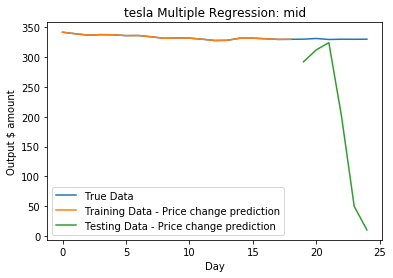

MSE: 100.59811131258598
alpha: 90
Training error = 3.163637954216078
Testing error = 7.41069331585236

                               0
volume_stdev           -0.228364
tesla_bad_stdev        -0.217410
mid_stdev              -0.209713
tesla_report_stdev     -0.196043
tesla_report_movingAvg -0.189694
tesla_stock_stdev      -0.169366
tesla_good_stdev       -0.165782
tesla_down_stdev       -0.161453
mid_movingAvg          -0.156280
mid_prev               -0.149737
tesla_up_stdev         -0.130974
tesla_good_movingAvg   -0.127730
tesla_bad_movingAvg    -0.108334
volume_movingAvg       -0.107519
tesla_report_prev      -0.095899
profit_prev            -0.084601
tesla_report           -0.061341
tesla_down_movingAvg   -0.059766
tesla_stock_movingAvg  -0.050414
profit_stdev           -0.022682
tesla_up_movingAvg      0.003115
tesla_good_prev         0.022127
tesla_good              0.031104
volume_prev             0.034068
tesla_bad_prev          0.062397
tesla_bad               0.067122
tesla_

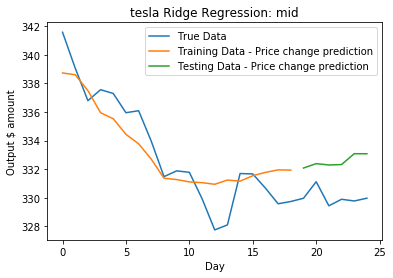

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.02056692479184649
facebook
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:24   Log-Likelihood:                 393.89
No. Observations:                  19   AIC:                            -749.8
Df Residuals:                       0   BIC:                            -731.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

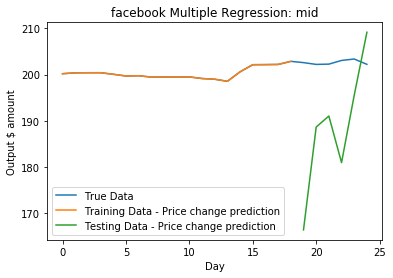

MSE: 1.8199787839019916
alpha: 1990
Training error = 0.2981395385353178
Testing error = 6.979879862799751

                                  0
profit_movingAvg          -0.007961
profit_prev               -0.006126
facebook_good             -0.004231
facebook_stock_prev       -0.004069
facebook_up               -0.003619
facebook_stock            -0.003441
facebook_good_prev        -0.001935
facebook_bad              -0.001206
facebook_stock_stdev      -0.001107
facebook_stock_movingAvg  -0.000693
facebook_report           -0.000669
facebook_up_prev          -0.000501
facebook_up_stdev         -0.000478
facebook_bad_movingAvg    -0.000040
facebook_up_movingAvg     -0.000036
facebook_good_movingAvg   -0.000027
facebook_down              0.000000
facebook_down_stdev        0.000000
facebook_bad_prev          0.000029
facebook_down_movingAvg    0.000094
facebook_down_prev         0.000098
mid_movingAvg              0.000119
mid_prev                   0.000459
facebook_report_prev       0.

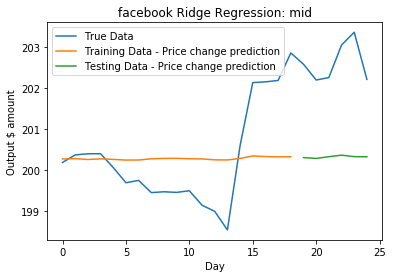

{'alpha': 1990, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.026761250244147983
microsoft


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:27   Log-Likelihood:                 379.87
No. Observations:                  19   AIC:                            -721.7
Df Residuals:                       0   BIC:                            -703.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

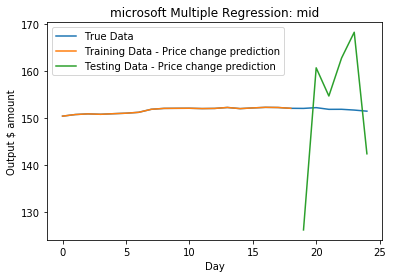

MSE: 1.344494238334001
alpha: 90
Training error = 0.057686503629781026
Testing error = 0.22546538090351737

                                   0
microsoft_bad              -0.012640
microsoft_up               -0.011232
microsoft_good             -0.011220
microsoft_stock            -0.007553
microsoft_stock_prev       -0.005906
microsoft_bad_prev         -0.005045
microsoft_down             -0.004388
microsoft_down_prev        -0.003323
profit_prev                -0.000764
microsoft_up_prev          -0.000345
microsoft_report            0.005473
microsoft_good_prev         0.005710
volume_prev                 0.005948
mid_prev                    0.011961
microsoft_good_stdev        0.012335
microsoft_report_prev       0.012830
profit_movingAvg            0.013686
profit_stdev                0.014407
mid_movingAvg               0.017822
microsoft_report_stdev      0.018956
microsoft_bad_movingAvg     0.019866
microsoft_down_movingAvg    0.019913
microsoft_up_movingAvg      0.021701
micr

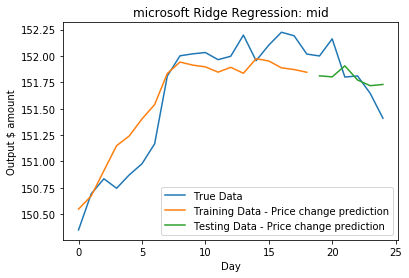

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.00031384786964145197
amazon


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:30   Log-Likelihood:                 364.35
No. Observations:                  19   AIC:                            -690.7
Df Residuals:                       0   BIC:                            -672.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

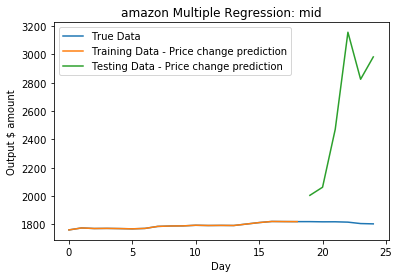

MSE: 435.64673513741553
alpha: 90
Training error = 29.75217182445729
Testing error = 941.3728864585889

                                0
profit_movingAvg        -1.474674
amazon_good             -0.656690
amazon_stock_prev       -0.491236
amazon_stock            -0.442187
profit_prev             -0.397583
amazon_up               -0.365173
amazon_down             -0.352307
amazon_down_prev        -0.309112
amazon_good_prev        -0.245128
amazon_bad              -0.226848
amazon_up_prev          -0.067903
amazon_bad_stdev         0.127906
amazon_report_stdev      0.130966
amazon_bad_prev          0.245878
amazon_down_movingAvg    0.271705
volume_prev              0.279399
amazon_bad_movingAvg     0.305703
amazon_down_stdev        0.384268
mid_movingAvg            0.409218
mid_prev                 0.442833
amazon_up_movingAvg      0.452632
volume_movingAvg         0.457600
amazon_good_movingAvg    0.479218
amazon_report_prev       0.574169
amazon_up_stdev          0.594446
amazon_stock

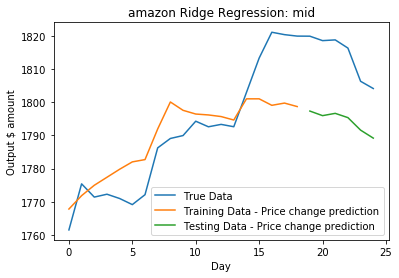

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.22020054624395266
google


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:34   Log-Likelihood:                 406.49
No. Observations:                  19   AIC:                            -775.0
Df Residuals:                       0   BIC:                            -757.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

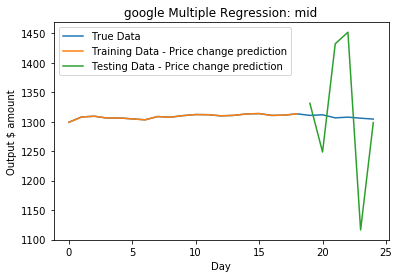

MSE: 9.809112440290953
alpha: 90
Training error = 5.74324312962313
Testing error = 11.23714899592043

                                0
profit_prev             -0.223980
google_good             -0.110439
google_up               -0.096847
google_stock            -0.088364
google_bad              -0.087130
google_stock_prev       -0.082751
google_down             -0.081632
google_report           -0.019296
google_good_prev        -0.009269
google_down_prev        -0.001213
google_up_stdev          0.005562
profit_movingAvg         0.017380
google_bad_prev          0.028051
google_bad_stdev         0.050658
google_stock_stdev       0.054109
google_down_stdev        0.065750
google_good_stdev        0.068096
google_up_prev           0.074202
google_report_stdev      0.074571
volume_prev              0.075928
mid_stdev                0.089055
google_good_movingAvg    0.093528
google_stock_movingAvg   0.097184
mid_movingAvg            0.098244
google_down_movingAvg    0.099069
google_bad_mov

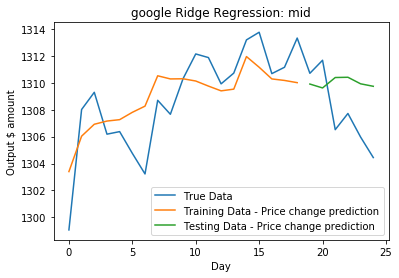

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.009051732239377067
uber


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:37   Log-Likelihood:                 402.76
No. Observations:                  19   AIC:                            -767.5
Df Residuals:                       0   BIC:                            -749.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.05

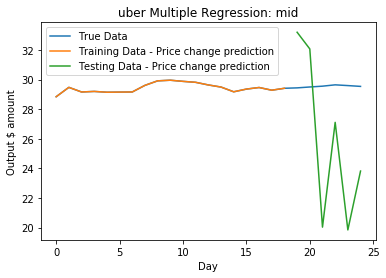

MSE: 1.3871672327751852
alpha: 1990
Training error = 0.09939864535094266
Testing error = 0.009940242001248475

                              0
uber_report           -0.001919
uber_down             -0.001323
uber_stock            -0.001233
uber_good             -0.001159
uber_down_prev        -0.001077
profit_movingAvg      -0.001047
uber_up               -0.000957
uber_stock_prev       -0.000843
uber_good_prev        -0.000560
uber_bad              -0.000377
uber_report_prev      -0.000232
uber_bad_prev         -0.000095
profit_prev            0.000227
uber_up_prev           0.000331
volume_prev            0.000726
profit_stdev           0.000765
uber_down_movingAvg    0.000821
uber_good_movingAvg    0.000856
uber_bad_movingAvg     0.000924
uber_report_movingAvg  0.001004
mid_movingAvg          0.001166
uber_stock_movingAvg   0.001178
uber_good_stdev        0.001275
volume_movingAvg       0.001343
mid_prev               0.001432
uber_report_stdev      0.001447
volume_stdev           0.

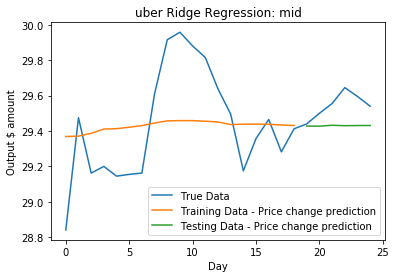

{'alpha': 1990, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0005955668377728368
lyft


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:40   Log-Likelihood:                 395.88
No. Observations:                  19   AIC:                            -753.8
Df Residuals:                       0   BIC:                            -735.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.24

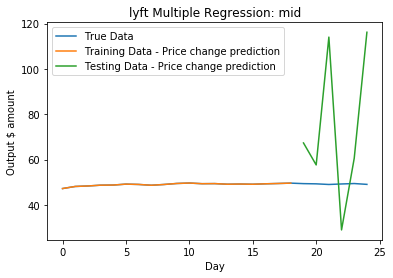

MSE: 32.739269314930795
alpha: 90
Training error = 0.07003922507966069
Testing error = 0.1742492079918918

                              0
volume_prev           -0.014607
lyft_report_prev      -0.008196
lyft_bad_prev         -0.006712
lyft_good_prev        -0.006600
lyft_stock_prev       -0.005948
profit_prev           -0.005545
lyft_good             -0.002023
lyft_report           -0.000549
lyft_up_prev           0.001690
profit_movingAvg       0.003790
lyft_stock             0.008964
lyft_report_stdev      0.010728
mid_stdev              0.011799
lyft_down_prev         0.012337
lyft_bad               0.012447
lyft_up                0.015014
lyft_bad_movingAvg     0.015437
volume_movingAvg       0.015648
volume_stdev           0.017325
lyft_down              0.017352
lyft_good_movingAvg    0.019035
lyft_up_stdev          0.019191
lyft_bad_stdev         0.019727
lyft_stock_movingAvg   0.020008
lyft_up_movingAvg      0.022563
lyft_report_movingAvg  0.023482
lyft_stock_stdev       0.0244

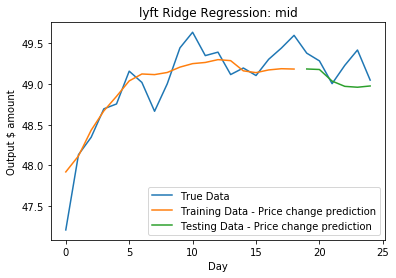

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0011233447528223878
apple


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:44   Log-Likelihood:                 384.72
No. Observations:                  19   AIC:                            -731.4
Df Residuals:                       0   BIC:                            -713.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

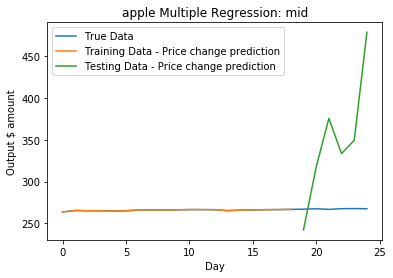

MSE: 43.93293258241906
alpha: 90
Training error = 0.19917484708211397
Testing error = 0.3254882800033812

                               0
profit_prev            -0.031743
apple_bad              -0.018556
apple_stock_prev       -0.010294
apple_up               -0.010126
apple_stock            -0.003485
apple_good             -0.001618
apple_down             -0.001064
apple_report           -0.000723
volume_prev             0.000123
apple_down_prev         0.004250
apple_up_prev           0.004476
profit_movingAvg        0.004936
apple_bad_prev          0.010709
apple_good_prev         0.015216
mid_movingAvg           0.019715
volume_movingAvg        0.020462
apple_good_movingAvg    0.020649
apple_down_movingAvg    0.020780
apple_up_movingAvg      0.020919
apple_bad_movingAvg     0.021975
apple_report_stdev      0.024139
apple_report_movingAvg  0.025214
apple_stock_movingAvg   0.025449
apple_bad_stdev         0.025770
profit_stdev            0.027289
apple_report_prev       0.027354
app

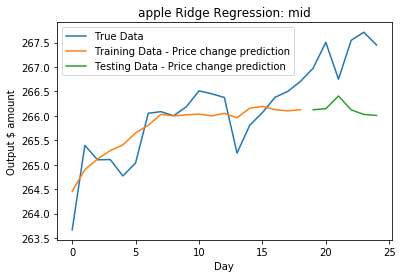

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0060008109898131035
snap


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:52:47   Log-Likelihood:                 414.99
No. Observations:                  19   AIC:                            -792.0
Df Residuals:                       0   BIC:                            -774.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.09

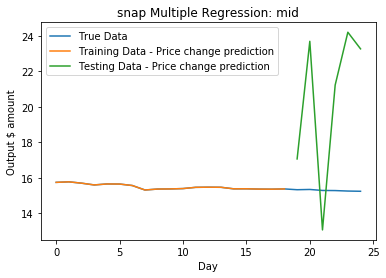

MSE: 2.8129940083431744
alpha: 90
Training error = 0.0031141903973238906
Testing error = 0.011331602871692251

                              0
volume_stdev          -0.007761
snap_down_stdev       -0.007024
profit_movingAvg      -0.006654
snap_up_stdev         -0.006589
snap_report_stdev     -0.006445
snap_stock_movingAvg  -0.006363
snap_down_movingAvg   -0.006246
snap_up_movingAvg     -0.006114
snap_good_movingAvg   -0.006032
snap_stock_stdev      -0.005891
snap_bad_movingAvg    -0.005663
volume_movingAvg      -0.005610
profit_stdev          -0.005507
snap_good_stdev       -0.005296
mid_movingAvg         -0.005213
snap_report_movingAvg -0.004909
profit_prev           -0.004855
snap_bad_stdev        -0.003445
mid_stdev             -0.002366
snap_up_prev          -0.002324
mid_prev              -0.001539
snap_down_prev        -0.000185
volume_prev           -0.000002
snap_bad_prev          0.000029
snap_report_prev       0.000497
snap_stock_prev        0.001540
snap_down              0.

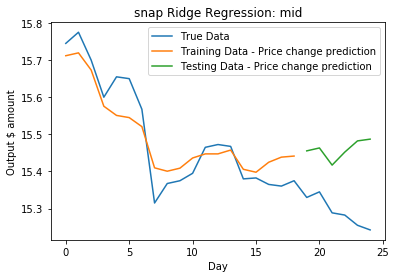

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0020329717868851757


In [21]:
MSE_dict = {} # {"company":{"multipleRegressionProfit":value, "multipleRegressionCost":value, etc}}
parameter_type = "allPredictors"
y_col='mid'

# Join data together, train various models
for company in companies: 
    print(company)
    
    # Initialize dictionary 
    MSE_dict[company] = {}
    MSE_dict[company]["MultipleRegression"] = {}
    MSE_dict[company]["RidgeRegression"] = {}
    
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    # Include moving average, stdev, and prev. 10 days. 
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    # Include movingAvg, stdev, and prev for all the Trends cols
    for col in cols: 
        # Prev info
        col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        df_all_data[col+'_prev'] = col_prev
        
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
        
        df_all_data[col+'_movingAvg'] = col_movingAvg
        df_all_data[col+'_stdev'] = col_stdev

    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:numTraining]
    df_all_data_test = df_all_data[numTraining:]
    

    
    if (MR): 
        MSE_dict[company]["MultipleRegression"][parameter_type] = {}


        # Multiple Regression, All Predictors
        
        close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
        print(close_multiple_regression_res.summary())
        MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
        MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    
    if (RR):
        MSE_dict[company]["RidgeRegression"][parameter_type] = {}
        # RIDGE REGRESSION REQUIRES STANDARDIZATION
        # Standardize the input parameters
        df_standardized_data = df_all_data.copy()

        for col in cols: 
            df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)

        # Split into training and testing data
        df_all_data_train = df_standardized_data[:numTraining]
        df_all_data_test = df_standardized_data[numTraining:]

        # Ridge Regression, All Predictors
        MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
        MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    
    


## Only Stock data

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     13.32
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           0.000339
Time:                        22:52:50   Log-Likelihood:                -27.188
No. Observations:                  19   AIC:                             74.38
Df Residuals:                       9   BIC:                             83.82
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          341.5540      1.470  

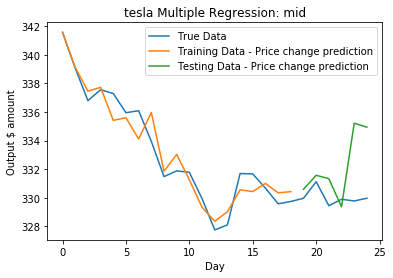

MSE: 0.02966327249259862
alpha: 90
Training error = 6.544142212639019
Testing error = 7.752759943740632

                         0
volume_stdev     -0.428971
mid_stdev        -0.399359
mid_movingAvg    -0.325739
volume_movingAvg -0.252654
mid_prev         -0.205884
profit_stdev     -0.117927
profit_prev      -0.016147
volume_prev       0.100077
profit_movingAvg  0.175853


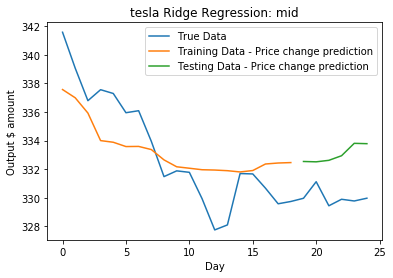

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.02967410032588681
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     21.32
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           4.95e-05
Time:                        22:52:53   Log-Likelihood:               -0.66345
No. Observations:                  19   AIC:                             21.33
Df Residuals:                       9   BIC:                             30.77
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err  

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


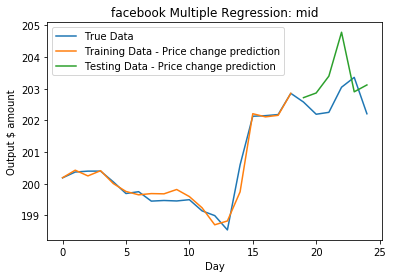

MSE: 0.0047992855382228495
alpha: 1990
Training error = 0.3216912420828711
Testing error = 6.886030418331337

                         0
profit_movingAvg -0.008000
profit_prev      -0.006169
mid_movingAvg     0.000089
mid_prev          0.000416
volume_movingAvg  0.001354
volume_prev       0.002609
volume_stdev      0.002708
profit_stdev      0.005742
mid_stdev         0.006572


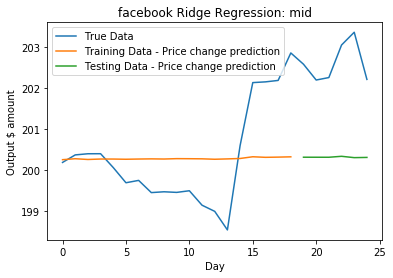

{'alpha': 1990, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.026975227084874296
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     63.33
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           4.61e-07
Time:                        22:52:56   Log-Likelihood:                 21.665
No. Observations:                  19   AIC:                            -23.33
Df Residuals:                       9   BIC:                            -13.88
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std er

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


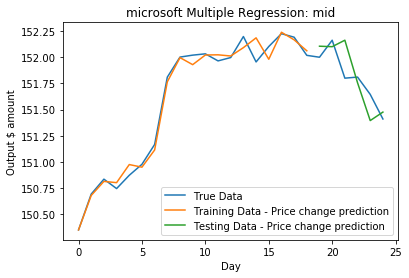

MSE: 0.00023756748016646822
alpha: 90
Training error = 0.11969557632309316
Testing error = 0.3774644129069028

                         0
profit_prev       0.009325
volume_prev       0.013498
profit_movingAvg  0.015300
mid_prev          0.029061
profit_stdev      0.039774
mid_stdev         0.044141
mid_movingAvg     0.050722
volume_movingAvg  0.066878
volume_stdev      0.074228


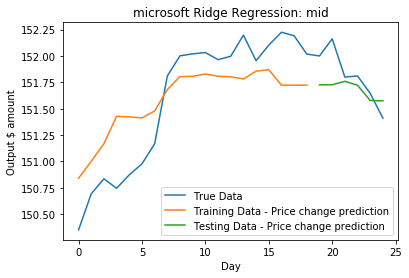

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.000335997895187986
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     14.82
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           0.000221
Time:                        22:52:58   Log-Likelihood:                -55.972
No. Observations:                  19   AIC:                             131.9
Df Residuals:                       9   BIC:                             141.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err 

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


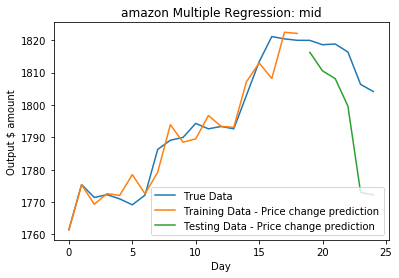

MSE: 0.2397623097395007
alpha: 90
Training error = 46.925267062135646
Testing error = 981.6973603065271

                         0
profit_movingAvg -1.952023
profit_prev      -0.445764
volume_prev       0.420200
mid_prev          0.683456
mid_movingAvg     0.940377
volume_movingAvg  0.993210
profit_stdev      1.221297
volume_stdev      1.322695
mid_stdev         1.548106


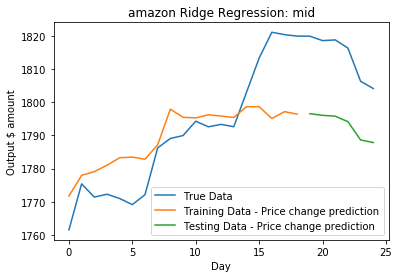

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.24425570592039406
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     24.71
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.67e-05
Time:                        22:53:01   Log-Likelihood:                -20.914
No. Observations:                  19   AIC:                             61.83
Df Residuals:                       9   BIC:                             71.27
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err  

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


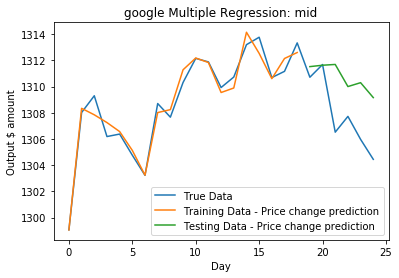

MSE: 0.009374613603209061
alpha: 90
Training error = 6.368946604769176
Testing error = 13.216998237448918

                         0
profit_prev      -0.207608
profit_movingAvg  0.033893
volume_prev       0.128864
mid_stdev         0.152616
mid_movingAvg     0.196925
volume_movingAvg  0.277260
volume_stdev      0.301474
mid_prev          0.311998
profit_stdev      0.336725


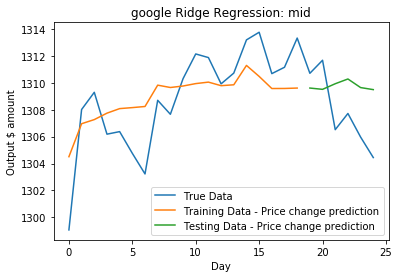

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.008063886540839574
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     12.48
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           0.000439
Time:                        22:53:03   Log-Likelihood:                 20.470
No. Observations:                  19   AIC:                            -20.94
Df Residuals:                       9   BIC:                            -11.49
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err 

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


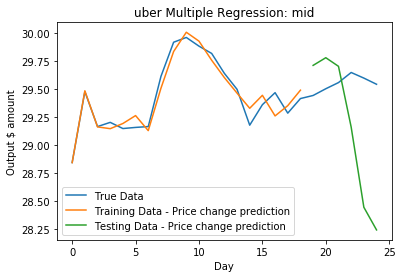

MSE: 0.01930946008988178
alpha: 1990
Training error = 0.10964916547949614
Testing error = 0.009068331824219938

                         0
profit_movingAvg -0.001114
profit_prev       0.000307
volume_prev       0.000669
profit_stdev      0.000900
mid_movingAvg     0.001339
volume_movingAvg  0.001507
mid_prev          0.001525
volume_stdev      0.001634
mid_stdev         0.001746


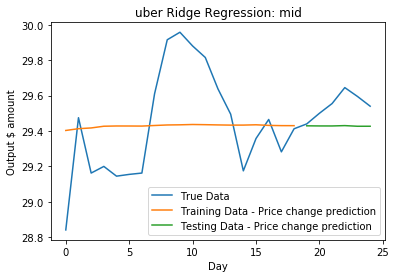

{'alpha': 1990, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0006117709997370785
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     22.90
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           3.68e-05
Time:                        22:53:06   Log-Likelihood:                 13.707
No. Observations:                  19   AIC:                            -7.415
Df Residuals:                       9   BIC:                             2.029
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std e

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


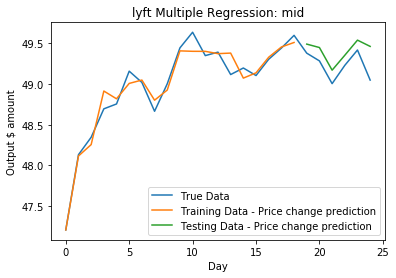

MSE: 0.0009113002042293274
alpha: 90
Training error = 0.1236979389288962
Testing error = 0.2251475316022583

                         0
volume_prev      -0.024575
profit_movingAvg  0.003631
profit_prev       0.010046
volume_movingAvg  0.035072
mid_stdev         0.036703
volume_stdev      0.040205
profit_stdev      0.049020
mid_movingAvg     0.058248
mid_prev          0.059388


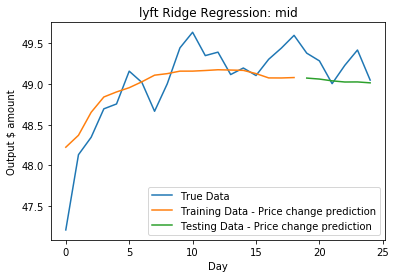

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0011600128727953154
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     17.39
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           0.000115
Time:                        22:53:09   Log-Likelihood:                 5.9514
No. Observations:                  19   AIC:                             8.097
Df Residuals:                       9   BIC:                             17.54
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


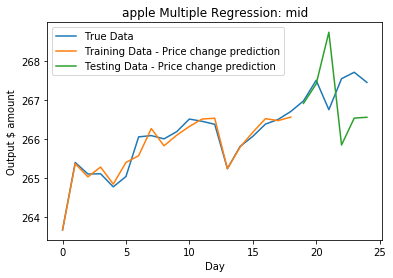

MSE: 0.005636367393738388
alpha: 90
Training error = 0.2857840001025775
Testing error = 0.4395738755923946

                         0
profit_prev      -0.019225
volume_prev       0.005000
profit_movingAvg  0.008622
profit_stdev      0.051010
volume_movingAvg  0.054453
mid_movingAvg     0.055008
volume_stdev      0.061597
mid_prev          0.066167
mid_stdev         0.067591


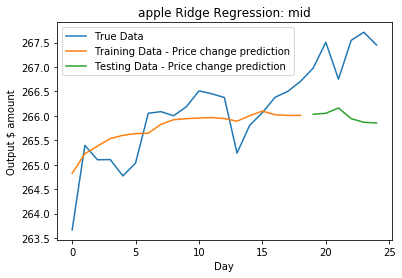

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.00739511698026574
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     16.93
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           0.000129
Time:                        22:53:11   Log-Likelihood:                 37.155
No. Observations:                  19   AIC:                            -54.31
Df Residuals:                       9   BIC:                            -44.87
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err  

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


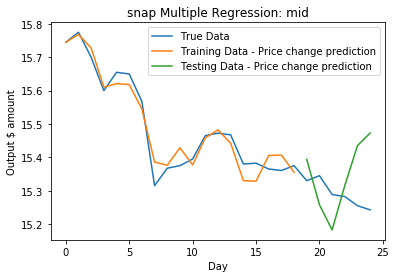

MSE: 0.001193527275471941
alpha: 90
Training error = 0.007495493102286154
Testing error = 0.014839567970118539

                         0
volume_stdev     -0.015331
volume_movingAvg -0.011755
mid_movingAvg    -0.011693
profit_movingAvg -0.011600
profit_stdev     -0.010843
profit_prev      -0.008281
mid_stdev        -0.006891
mid_prev         -0.004482
volume_prev       0.000917


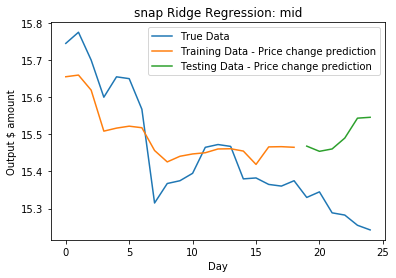

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.003040885919354448


In [22]:
# Only Stock Data
parameter_type = "noTrend"
y_col='mid'

for company in companies: 
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    # Include moving average, stdev, and prev. 10 days. 
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    #### Predictions using only stock market data #### 
    # Remove any cols in col that has the company name in it. 
    cols_noTrends = [col for col in cols if company not in col]
    cols = cols_noTrends
    
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:numTraining]
    df_all_data_test = df_all_data[numTraining:]
    
    if (MR): # Multiple Regression
        MSE_dict[company]["MultipleRegression"][parameter_type] = {}
        close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
        print(close_multiple_regression_res.summary())
        MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
        MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    
    if (RR) : # Ridge Regression
        MSE_dict[company]["RidgeRegression"][parameter_type] = {}
        
        # Standardize the input parameters
        df_standardized_data = df_all_data.copy()

        for col in cols: 
            df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)

        # Split into training and testing data
        df_all_data_train = df_standardized_data[:numTraining]
        df_all_data_test = df_standardized_data[numTraining:]

        # Ridge Regression
        MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
        MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    

## Predicting with only Google Trends data

tesla


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:15   Log-Likelihood:                 479.77
No. Observations:                  19   AIC:                            -921.5
Df Residuals:                       0   BIC:                            -903.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

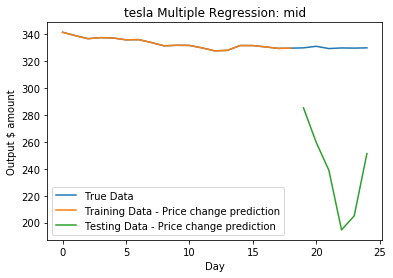

MSE: 27.959685603521198
alpha: 90
Training error = 4.090561844299234
Testing error = 9.267853295650648

                               0
tesla_bad_stdev        -0.265749
tesla_report_movingAvg -0.248150
tesla_report_stdev     -0.246310
tesla_stock_stdev      -0.209187
tesla_good_stdev       -0.206706
tesla_down_stdev       -0.204058
tesla_up_stdev         -0.174787
tesla_good_movingAvg   -0.172896
tesla_bad_movingAvg    -0.152702
tesla_report_prev      -0.125327
tesla_down_movingAvg   -0.093901
tesla_stock_movingAvg  -0.078511
tesla_report           -0.070239
tesla_up_movingAvg     -0.026348
tesla_good_prev         0.019681
tesla_good              0.031906
tesla_bad_prev          0.063825
tesla_up_prev           0.069595
tesla_down_prev         0.075030
tesla_stock             0.077737
tesla_bad               0.082491
tesla_stock_prev        0.090077
tesla_down              0.097318
tesla_up                0.197884


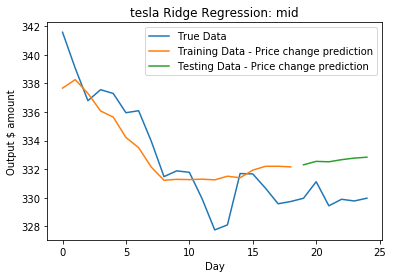

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.021139455279526258
facebook


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:18   Log-Likelihood:                 482.73
No. Observations:                  19   AIC:                            -927.5
Df Residuals:                       0   BIC:                            -909.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

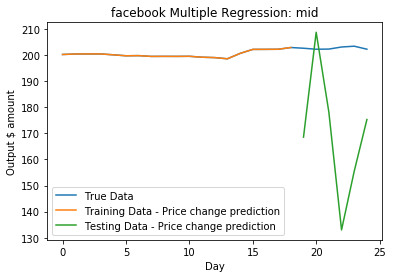

MSE: 7.986533410767047
alpha: 1990
Training error = 0.3042362260822149
Testing error = 6.943581038062394

                                  0
facebook_good             -0.004288
facebook_stock_prev       -0.004101
facebook_up               -0.003671
facebook_stock            -0.003474
facebook_good_prev        -0.001916
facebook_bad              -0.001225
facebook_stock_stdev      -0.001031
facebook_report           -0.000632
facebook_stock_movingAvg  -0.000616
facebook_up_prev          -0.000449
facebook_up_stdev         -0.000406
facebook_down              0.000000
facebook_down_stdev        0.000000
facebook_bad_movingAvg     0.000031
facebook_up_movingAvg      0.000040
facebook_good_movingAvg    0.000049
facebook_bad_prev          0.000071
facebook_down_prev         0.000127
facebook_down_movingAvg    0.000159
facebook_report_prev       0.000706
facebook_report_movingAvg  0.000985
facebook_good_stdev        0.001664
facebook_bad_stdev         0.002017
facebook_report_stdev      0.0

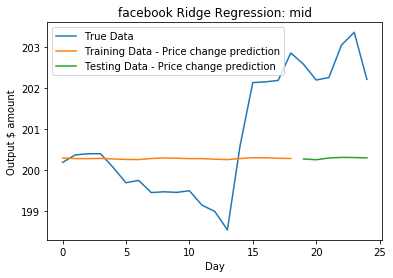

{'alpha': 1990, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.027521952473395915
microsoft
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:22   Log-Likelihood:                 510.49
No. Observations:                  19   AIC:                            -983.0
Df Residuals:                       0   BIC:                            -965.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

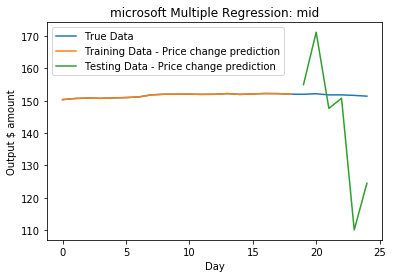

MSE: 3.1156639363527137
alpha: 90
Training error = 0.08733230639922694
Testing error = 0.18174225339846434

                                   0
microsoft_bad              -0.013487
microsoft_up               -0.012968
microsoft_good             -0.010742
microsoft_stock            -0.009054
microsoft_stock_prev       -0.006729
microsoft_down             -0.005444
microsoft_bad_prev         -0.004332
microsoft_down_prev        -0.001930
microsoft_up_prev           0.002044
microsoft_report            0.006780
microsoft_good_prev         0.008589
microsoft_good_stdev        0.016983
microsoft_report_prev       0.017180
microsoft_report_stdev      0.025932
microsoft_bad_movingAvg     0.026195
microsoft_down_movingAvg    0.026756
microsoft_up_movingAvg      0.029009
microsoft_report_movingAvg  0.031015
microsoft_good_movingAvg    0.031619
microsoft_stock_movingAvg   0.035725
microsoft_bad_stdev         0.037774
microsoft_stock_stdev       0.040653
microsoft_down_stdev        0.042634
micr

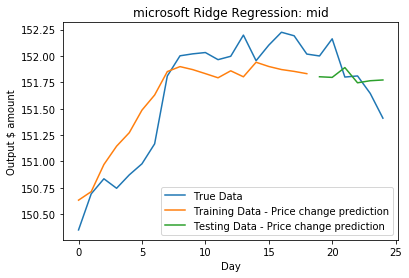

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.00036297858300893705
amazon
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:24   Log-Likelihood:                 457.65
No. Observations:                  19   AIC:                            -877.3
Df Residuals:                       0   BIC:                            -859.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

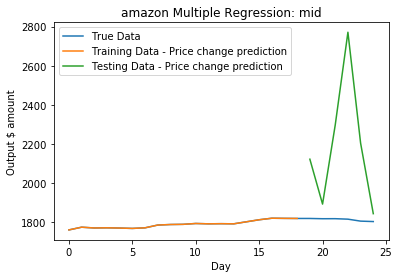

MSE: 128.3677257838588
alpha: 90
Training error = 47.702637658719595
Testing error = 1063.9447480907781

                                0
amazon_good             -0.738249
amazon_stock_prev       -0.599350
amazon_stock            -0.502110
amazon_down             -0.445782
amazon_up               -0.443809
amazon_down_prev        -0.350628
amazon_bad              -0.331405
amazon_good_prev        -0.250942
amazon_up_prev          -0.028869
amazon_bad_prev          0.331467
amazon_report_stdev      0.387735
amazon_bad_stdev         0.394746
amazon_down_movingAvg    0.477474
amazon_bad_movingAvg     0.499542
amazon_report_prev       0.669335
amazon_down_stdev        0.676758
amazon_up_movingAvg      0.699506
amazon_good_movingAvg    0.731219
amazon_report            0.814174
amazon_stock_stdev       0.889914
amazon_stock_movingAvg   0.892880
amazon_up_stdev          0.898041
amazon_report_movingAvg  1.004734
amazon_good_stdev        1.145516


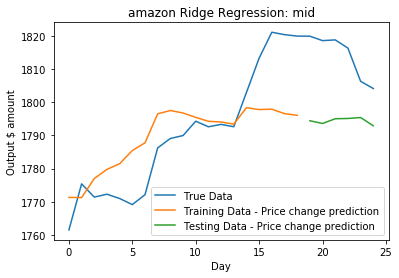

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.23339452872658914
google
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:27   Log-Likelihood:                 436.15
No. Observations:                  19   AIC:                            -834.3
Df Residuals:                       0   BIC:                            -816.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coe

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

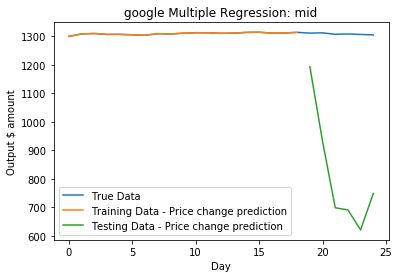

MSE: 214.91003233402756
alpha: 90
Training error = 8.06327558310376
Testing error = 12.218132216630575

                                0
google_good             -0.133619
google_up               -0.113093
google_stock            -0.112649
google_bad              -0.103826
google_down             -0.102422
google_stock_prev       -0.074661
google_report           -0.030420
google_good_prev         0.016186
google_down_prev         0.024033
google_up_stdev          0.038596
google_bad_prev          0.063963
google_bad_stdev         0.082577
google_stock_stdev       0.092368
google_down_stdev        0.105919
google_good_stdev        0.109352
google_report_stdev      0.114440
google_up_prev           0.116650
google_good_movingAvg    0.141601
google_stock_movingAvg   0.145646
google_down_movingAvg    0.146834
google_bad_movingAvg     0.151894
google_up_movingAvg      0.159351
google_report_movingAvg  0.160558
google_report_prev       0.175028


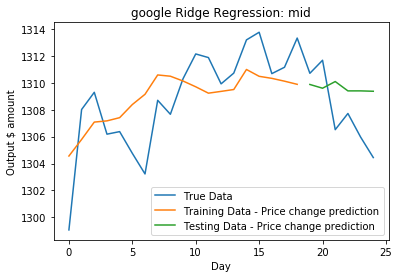

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.007240497229885196
uber
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:29   Log-Likelihood:                 573.48
No. Observations:                  19   AIC:                            -1109.
Df Residuals:                       0   BIC:                            -1091.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef  

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

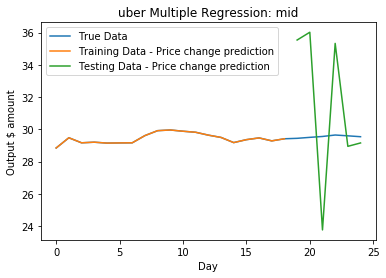

MSE: 0.823692239402643
alpha: 1990
Training error = 0.10258880001192973
Testing error = 0.009344994507175446

                              0
uber_report           -0.001972
uber_down             -0.001346
uber_stock            -0.001256
uber_good             -0.001193
uber_down_prev        -0.001081
uber_up               -0.000974
uber_stock_prev       -0.000843
uber_good_prev        -0.000547
uber_bad              -0.000407
uber_report_prev      -0.000229
uber_bad_prev         -0.000089
uber_up_prev           0.000358
uber_down_movingAvg    0.000852
uber_good_movingAvg    0.000915
uber_bad_movingAvg     0.000974
uber_report_movingAvg  0.001060
uber_stock_movingAvg   0.001222
uber_good_stdev        0.001336
uber_report_stdev      0.001505
uber_up_movingAvg      0.001556
uber_bad_stdev         0.001616
uber_down_stdev        0.001873
uber_up_stdev          0.002106
uber_stock_stdev       0.002234


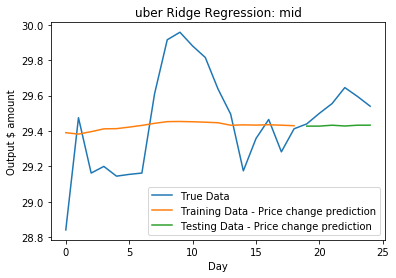

{'alpha': 1990, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0005937585748843446
lyft


c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:32   Log-Likelihood:                 541.89
No. Observations:                  19   AIC:                            -1046.
Df Residuals:                       0   BIC:                            -1028.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.84

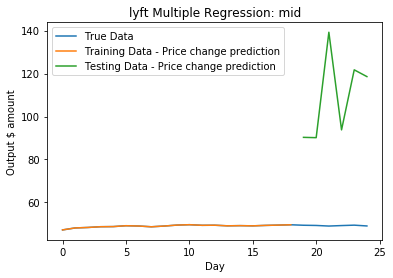

MSE: 79.68562065018345
alpha: 90
Training error = 0.09676415947435375
Testing error = 0.16879463122625177

                              0
lyft_bad_prev         -0.007291
lyft_report_prev      -0.006349
lyft_stock_prev       -0.005210
lyft_good_prev        -0.004370
lyft_good             -0.002947
lyft_report           -0.000348
lyft_up_prev           0.003739
lyft_stock             0.009586
lyft_bad               0.012855
lyft_report_stdev      0.015243
lyft_down_prev         0.015528
lyft_up                0.016820
lyft_down              0.020950
lyft_bad_movingAvg     0.021751
lyft_up_stdev          0.025233
lyft_bad_stdev         0.026136
lyft_good_movingAvg    0.027088
lyft_stock_movingAvg   0.027465
lyft_up_movingAvg      0.029894
lyft_stock_stdev       0.031279
lyft_report_movingAvg  0.031332
lyft_good_stdev        0.036362
lyft_down_movingAvg    0.036913
lyft_down_stdev        0.038650


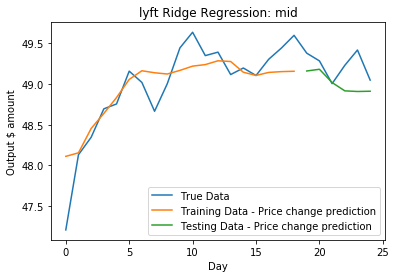

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0014781009784573865
apple
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:36   Log-Likelihood:                 479.75
No. Observations:                  19   AIC:                            -921.5
Df Residuals:                       0   BIC:                            -903.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coe

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

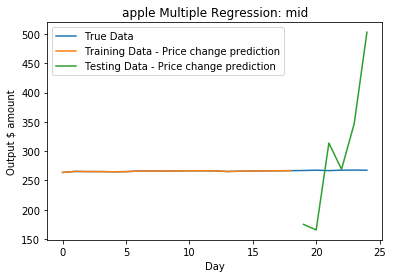

MSE: 51.662264484662536
alpha: 90
Training error = 0.2521939419906676
Testing error = 0.3535156925064513

                               0
apple_bad              -0.016645
apple_stock_prev       -0.012774
apple_up               -0.010635
apple_stock            -0.003804
apple_report           -0.001911
apple_good             -0.001512
apple_down              0.000201
apple_down_prev         0.005574
apple_up_prev           0.006498
apple_bad_prev          0.015671
apple_good_prev         0.019781
apple_down_movingAvg    0.028284
apple_good_movingAvg    0.028455
apple_up_movingAvg      0.028541
apple_bad_movingAvg     0.030089
apple_report_stdev      0.031005
apple_report_prev       0.032065
apple_bad_stdev         0.032687
apple_stock_movingAvg   0.032735
apple_report_movingAvg  0.033528
apple_good_stdev        0.036192
apple_stock_stdev       0.038526
apple_down_stdev        0.038870
apple_up_stdev          0.040215


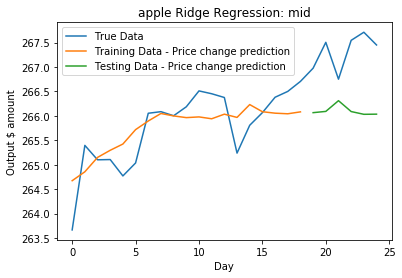

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.006216553929341818
snap
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                nan
Time:                        22:53:39   Log-Likelihood:                 556.67
No. Observations:                  19   AIC:                            -1075.
Df Residuals:                       0   BIC:                            -1057.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef  

c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
c:\users\edward\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide

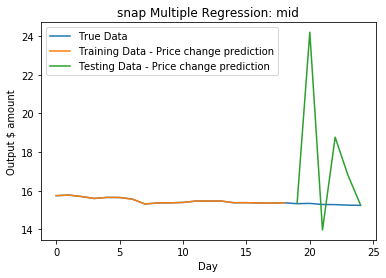

MSE: 1.0335297518362845
alpha: 90
Training error = 0.004281835493023897
Testing error = 0.012920765293624908

                              0
snap_down_stdev       -0.009224
snap_up_stdev         -0.008656
snap_down_movingAvg   -0.008378
snap_stock_movingAvg  -0.008176
snap_good_movingAvg   -0.008137
snap_up_movingAvg     -0.008126
snap_report_stdev     -0.008021
snap_bad_movingAvg    -0.007732
snap_stock_stdev      -0.007687
snap_good_stdev       -0.006921
snap_report_movingAvg -0.006567
snap_bad_stdev        -0.004817
snap_up_prev          -0.002992
snap_down_prev        -0.000833
snap_bad_prev         -0.000522
snap_report_prev       0.001180
snap_down              0.001575
snap_stock_prev        0.001916
snap_good_prev         0.002021
snap_bad               0.002863
snap_up                0.003361
snap_good              0.004075
snap_report            0.006401
snap_stock             0.006675


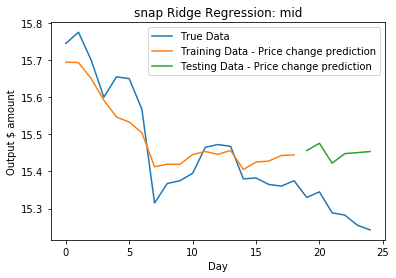

{'alpha': 90, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
MSE: 0.0017575455041842873


In [23]:
# Join data together, train various models
parameter_type="onlyTrends"
y_col='mid'
for company in companies: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    num_days_to_average = 10
    for col in cols: 
        # Prev to today increment amount
        col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        df_all_data[col+'_prev'] = col_prev
        
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
        
        df_all_data[col+'_movingAvg'] = col_movingAvg
        df_all_data[col+'_stdev'] = col_stdev

    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:numTraining]
    df_all_data_test = df_all_data[numTraining:]
    
    if (MR): 
        MSE_dict[company]["MultipleRegression"][parameter_type] = {}
        # Profit prediction: 
        close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
        print(close_multiple_regression_res.summary())
        MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
        MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    
    if (RR): 
        MSE_dict[company]["RidgeRegression"][parameter_type] = {}
        # Standardize the input parameters
        df_standardized_data = df_all_data.copy()

        for col in cols: 
            df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)

        # Split into training and testing data
        df_all_data_train = df_standardized_data[:numTraining]
        df_all_data_test = df_standardized_data[numTraining:]

        # Ridge Regression
        MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
        MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    

In [24]:
def plotMSE(y_col, model):
    numBetter = 0
    totalCompanies = 0
    for company in companies[0:3] + companies[3:]:
        allPredictors = MSE_dict[company][model]['allPredictors'][y_col]
        onlyTrends = MSE_dict[company][model]['onlyTrends'][y_col]
        noTrends = MSE_dict[company][model]['noTrend'][y_col]
        plt.plot(["all predictors", "only trends", "only stocks"], [allPredictors, onlyTrends, noTrends], label=company)
        
        if(allPredictors < noTrends) or (onlyTrends < noTrends):
            numBetter += 1
            print(">>", company,[allPredictors, onlyTrends, noTrends])
        else : print("  ",company,[allPredictors, onlyTrends, noTrends])

        totalCompanies += 1
    print("numBetter:", numBetter, "out of:",  totalCompanies)
    print("percent better:", numBetter / totalCompanies)

    
    # plt.xlabel("parameter types")
    plt.ylabel("MSE / mean stock price")
    plt.legend()
    plt.title("Hourly " + model + " " + y_col)
    
    
    

   tesla [100.59811131258598, 27.959685603521198, 0.02966327249259862]
   facebook [1.8199787839019916, 7.986533410767047, 0.0047992855382228495]
   microsoft [1.344494238334001, 3.1156639363527137, 0.00023756748016646822]
   amazon [435.64673513741553, 128.3677257838588, 0.2397623097395007]
   google [9.809112440290953, 214.91003233402756, 0.009374613603209061]
   uber [1.3871672327751852, 0.823692239402643, 0.01930946008988178]
   lyft [32.739269314930795, 79.68562065018345, 0.0009113002042293274]
   apple [43.93293258241906, 51.662264484662536, 0.005636367393738388]
   snap [2.8129940083431744, 1.0335297518362845, 0.001193527275471941]
numBetter: 0 out of: 9
percent better: 0.0


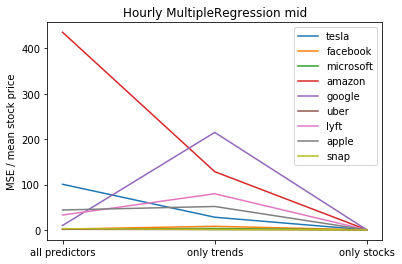

In [25]:
y_col = "mid"
model = "MultipleRegression"
plotMSE(y_col, model)

>> tesla [0.02056692479184649, 0.021139455279526258, 0.02967410032588681]
>> facebook [0.026761250244147983, 0.027521952473395915, 0.026975227084874296]
>> microsoft [0.00031384786964145197, 0.00036297858300893705, 0.000335997895187986]
>> amazon [0.22020054624395266, 0.23339452872658914, 0.24425570592039406]
>> google [0.009051732239377067, 0.007240497229885196, 0.008063886540839574]
>> uber [0.0005955668377728368, 0.0005937585748843446, 0.0006117709997370785]
>> lyft [0.0011233447528223878, 0.0014781009784573865, 0.0011600128727953154]
>> apple [0.0060008109898131035, 0.006216553929341818, 0.00739511698026574]
>> snap [0.0020329717868851757, 0.0017575455041842873, 0.003040885919354448]
numBetter: 9 out of: 9
percent better: 1.0


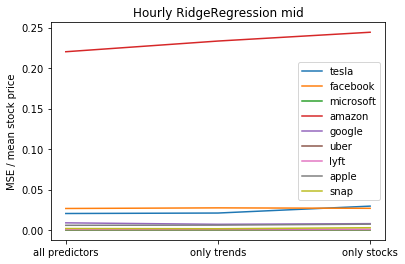

In [26]:
y_col = "mid"
model = "RidgeRegression"
plotMSE(y_col, model)

## Tensorflow + Keras time

In [27]:
# scale data to be between 0-1 
def predictCompany(df_temp, train_size, cols):
    # scale data to be between 0-1 including average
    sc = MinMaxScaler(feature_range = (0, 1))
    data_set_scaled = sc.fit_transform(df_temp[cols+['mid']])
    
    #split training data 
    train = data_set_scaled[:train_size, :]
    test = data_set_scaled[train_size:, :]
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    #create model
    model = Sequential()
    model.add(LSTM(train_size, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    #train model
    history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    return history, model, train_X, train_y, test_X, test_y

In [28]:
def plotPrediction(company, train_size, model, train_X, train_y, test_X, test_y):
    plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(len(train_y)), model.predict(train_X), '-', range(len(train_y), len(train_y)+len(test_y)), model.predict(test_X), '-')
    plt.xlabel('Day')
    plt.ylabel('Profit from previous day')
    plt.title(company + ' - predicting stock market with Keras')
    plt.legend(["True Data","Training Data", "Testing Data"])
    plt.show()

In [29]:
def plotHistory(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

tesla


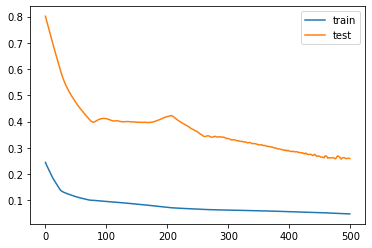

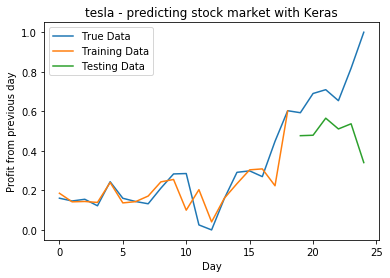

facebook


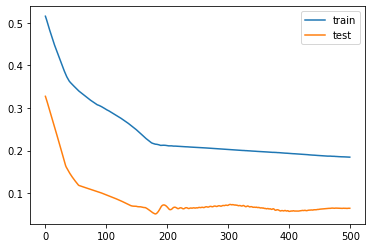

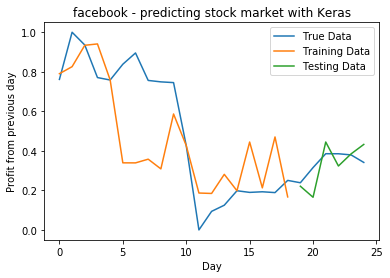

microsoft


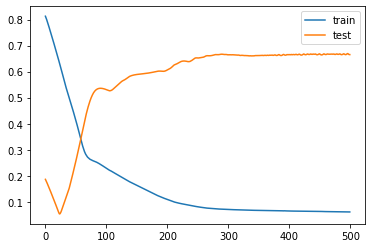

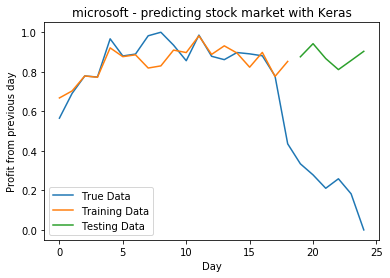

amazon


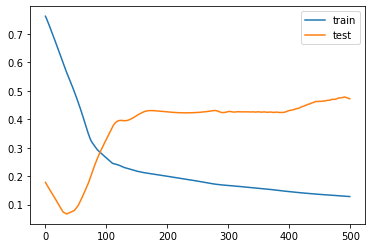

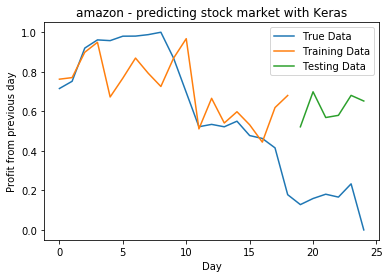

google


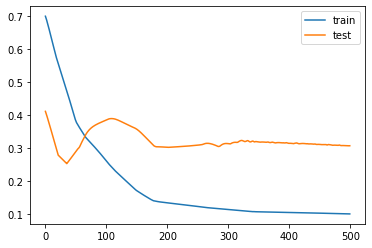

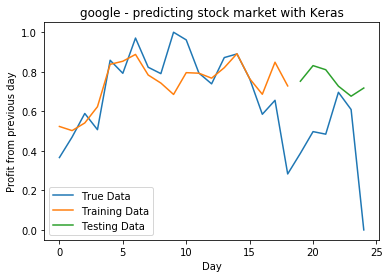

uber


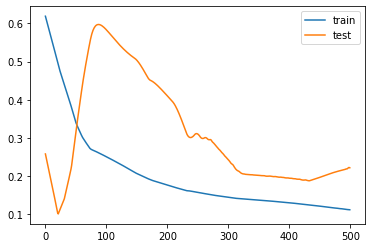

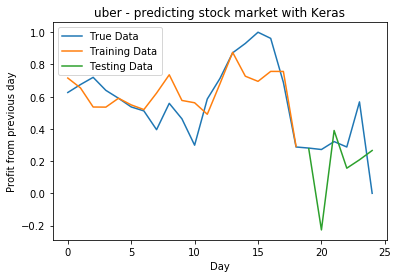

lyft


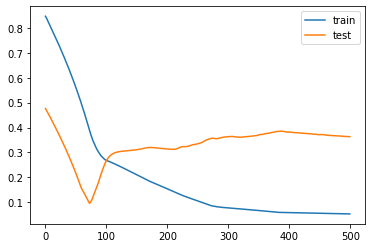

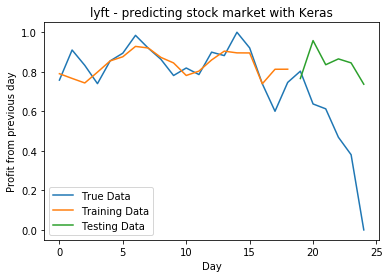

apple


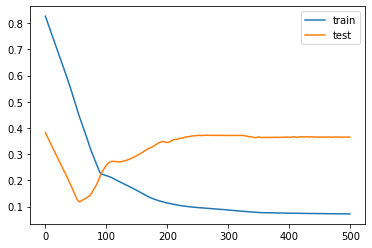

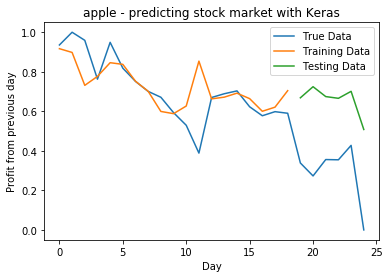

snap


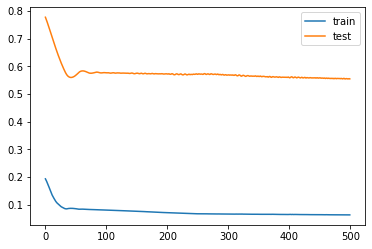

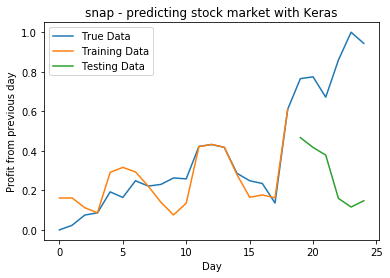

In [30]:
#Trends only!
MSE_train_trends_only = []
MSE_test_trends_only = []
for company in companies: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    # Plotting only Google Trends data 
    history, model, train_X, train_y, test_X, test_y = predictCompany(df_all_data, 19, cols)
    plotHistory(history)
    plotPrediction(company, 19, model, train_X, train_y, test_X, test_y)
    MSE_train_trends_only.append((company, mean_squared_error(model.predict(train_X), train_y)))
    MSE_test_trends_only.append((company, mean_squared_error(model.predict(test_X), test_y)))


tesla


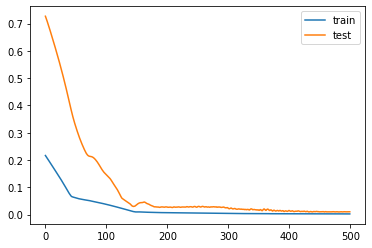

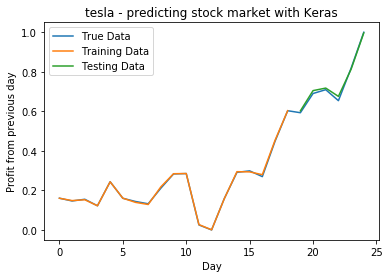

facebook


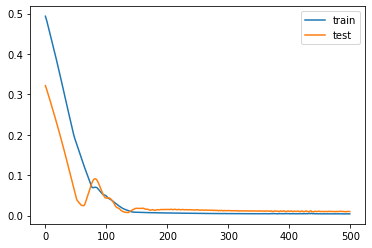

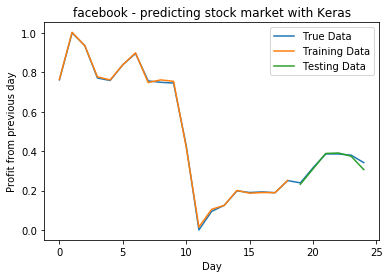

microsoft


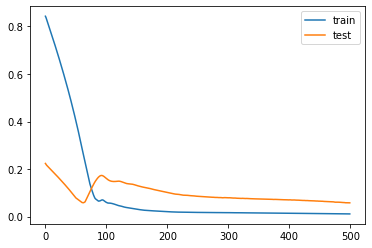

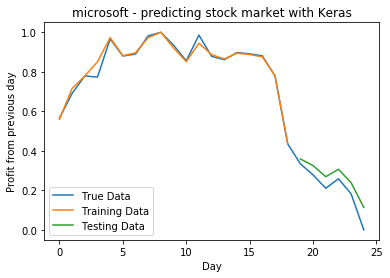

amazon


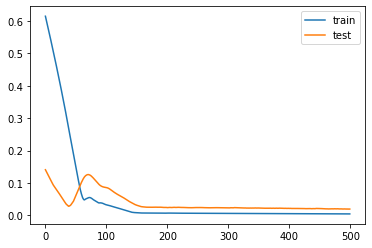

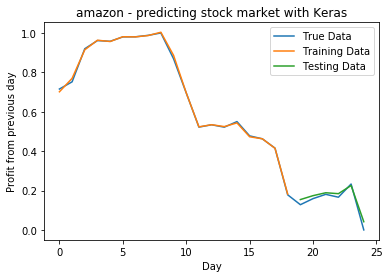

google


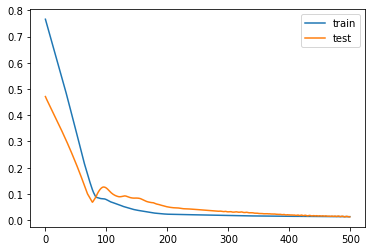

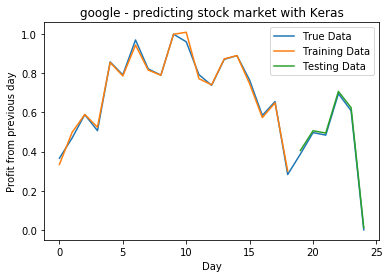

uber


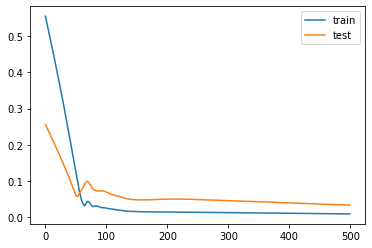

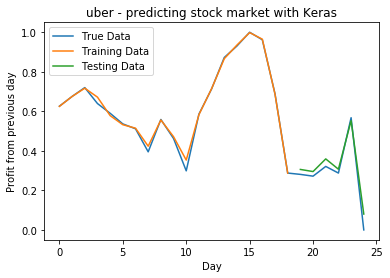

lyft


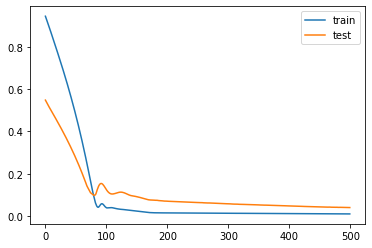

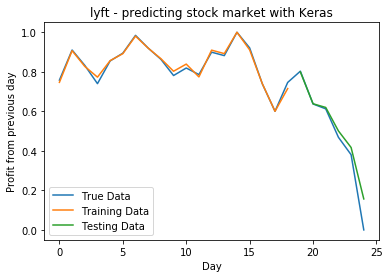

apple


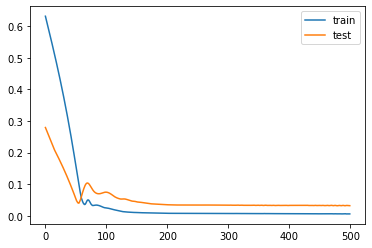

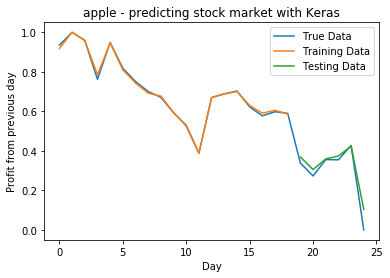

snap


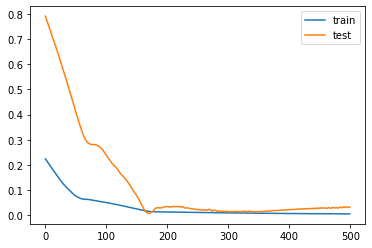

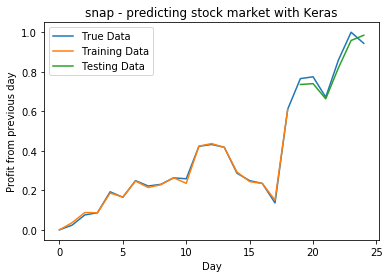

In [31]:
#Stock only!
MSE_train_stock_only = []
MSE_test_stock_only = []
for company in companies: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = stock_columns
    
    # Plotting only Google Trends data 
    history, model, train_X, train_y, test_X, test_y = predictCompany(df_all_data, 19, cols)
    plotHistory(history)
    plotPrediction(company, 19, model, train_X, train_y, test_X, test_y)
    MSE_train_stock_only.append((company, mean_squared_error(model.predict(train_X), train_y)))
    MSE_test_stock_only.append((company, mean_squared_error(model.predict(test_X), test_y)))


tesla


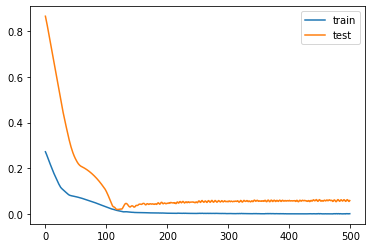

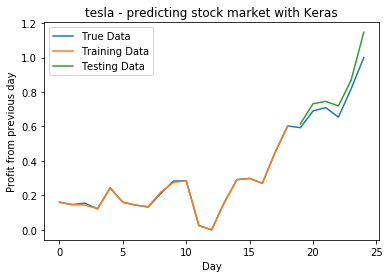

facebook


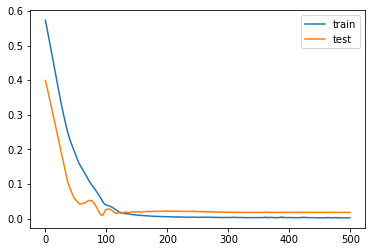

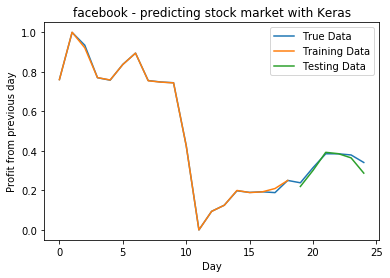

microsoft


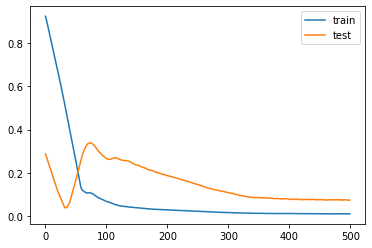

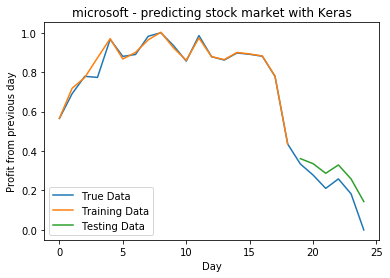

amazon


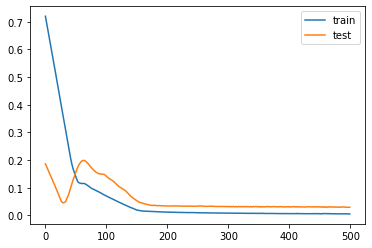

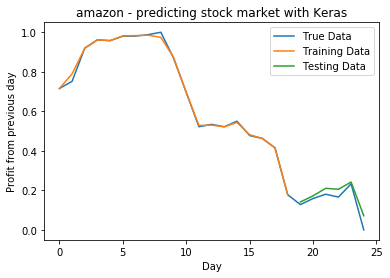

google


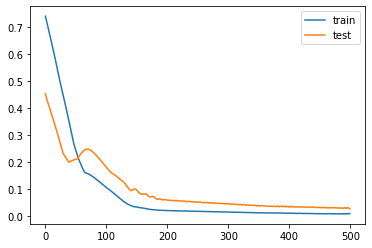

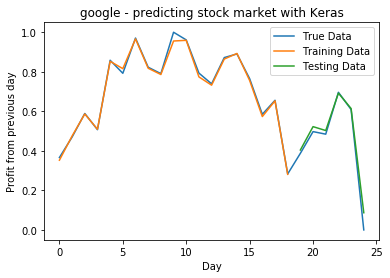

uber


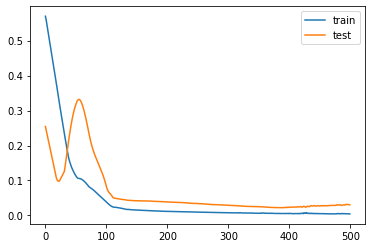

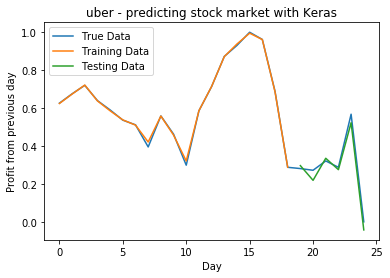

lyft


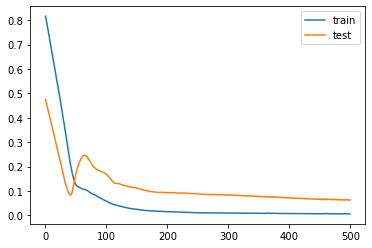

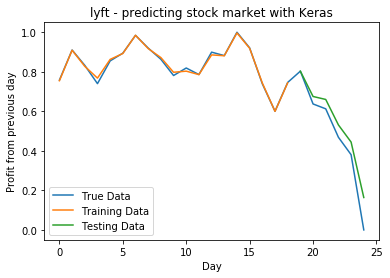

apple


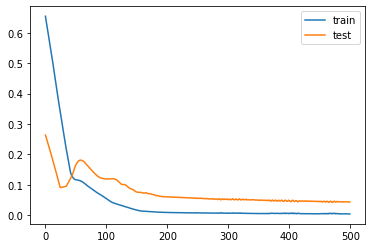

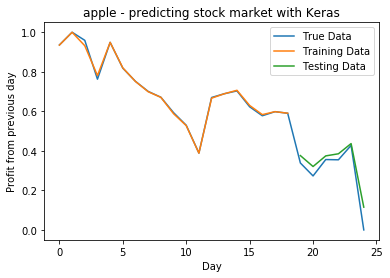

snap


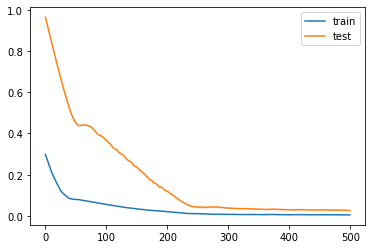

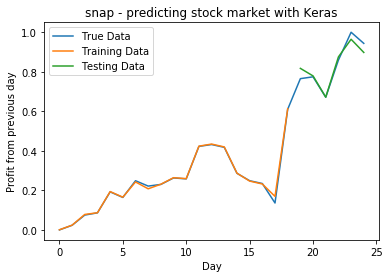

In [32]:
#both trends and stock!
MSE_train_both = []
MSE_test_both = []
for company in companies: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data) + stock_columns
    
    # Plotting only Google Trends data 
    history, model, train_X, train_y, test_X, test_y = predictCompany(df_all_data, 19, cols)
    plotHistory(history)
    plotPrediction(company, 19, model, train_X, train_y, test_X, test_y)
    MSE_train_both.append((company, mean_squared_error(model.predict(train_X), train_y)))
    MSE_test_both.append((company, mean_squared_error(model.predict(test_X), test_y)))


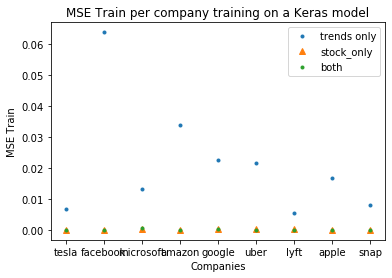

In [33]:
#plot MSE_train data points as scatter plots
X = [x[0] for x in MSE_train_both]
trends_only = [x[1] for x in MSE_train_trends_only]
stock_only = [x[1] for x in MSE_train_stock_only]
both = [x[1] for x in MSE_train_both]
fig, ax = plt.subplots()
plt.plot(X,trends_only, '.', X, stock_only, '^', X, both, '.')
plt.xlabel('Companies')
plt.ylabel('MSE Train')
plt.title('MSE Train per company training on a Keras model')
ax.legend(['trends only', 'stock_only', 'both'])
plt.show()

   tesla [0.005311134691288727, 0.10221403170732306, 0.0001458645470736889]
   facebook [0.0006198147186670281, 0.006420838981532524, 0.0002309676892922282]
   microsoft [0.006889782914125138, 0.4567382366164174, 0.004110000136070434]
   amazon [0.0013381377300596513, 0.23223054456427975, 0.0005128817850788835]
   google [0.0014752106287283099, 0.14525744148518197, 0.00016963141362419376]
>> uber [0.0012085117562988489, 0.07853618650679813, 0.0016080235015414916]
   lyft [0.006424084317166207, 0.17836202393418576, 0.004499296764916189]
   apple [0.0030475890566515704, 0.14059259098401508, 0.002187733213400935]
>> snap [0.0010578464975982437, 0.36793151331019286, 0.0011891904005441043]
numBetter: 2 out of: 9
percent better: 0.2222222222222222


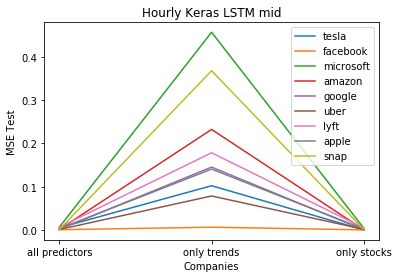

In [43]:
#plot MSE_test data points as scatter plots
X = [x[0] for x in MSE_test_both]
trends_only = [x[1] for x in MSE_test_trends_only]
stock_only = [x[1] for x in MSE_test_stock_only]
both = [x[1] for x in MSE_test_both]
fig, ax = plt.subplots()
numBetter = 0
totalCompanies = 0
for i,c in enumerate(companies):
    plt.plot(["all predictors", "only trends", "only stocks"], [both[i], trends_only[i], stock_only[i]], label=c)
    if(both[i] < stock_only[i]) or (trends_only[i] < stock_only[i]):
        numBetter += 1
        print(">>", c,[both[i], trends_only[i], stock_only[i]])
    else : print("  ",c,[both[i], trends_only[i], stock_only[i]])
    totalCompanies += 1
print("numBetter:", numBetter, "out of:",  totalCompanies)
print("percent better:", numBetter / totalCompanies)
plt.xlabel('Companies')
plt.ylabel('MSE Test')
plt.legend()
plt.title("Hourly " + 'Keras LSTM' + " mid")
plt.show()

In [ ]:
def plotMSE(y_col, model):
    numBetter = 0
    totalCompanies = 0
    for company in companies:
        allPredictors = MSE_dict[company][model]['allPredictors'][y_col]
        onlyTrends = MSE_dict[company][model]['onlyTrends'][y_col]
        noTrends = MSE_dict[company][model]['noTrend'][y_col]
        plt.plot(["all predictors", "only trends", "only stocks"], [allPredictors, onlyTrends, noTrends], label=company)
        
        if(allPredictors < noTrends) or (onlyTrends < noTrends):
            numBetter += 1
            print(">>", company,[allPredictors, onlyTrends, noTrends])
        else : print("  ",company,[allPredictors, onlyTrends, noTrends])

        totalCompanies += 1
    print("numBetter:", numBetter, "out of:",  totalCompanies)
    print("percent better:", numBetter / totalCompanies)

    
    # plt.xlabel("parameter types")
    plt.ylabel("MSE / mean stock price")
    plt.legend()
    plt.title("Daily " + model + " " + y_col)

# Lasso Regression with Hourly Data

In [ ]:
# Imports
import requests
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn import linear_model
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path


**Helper Functions**

In [ ]:
def save_dict_df(dictex, keys_filename="keys.txt", data_folder="hourly_stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="hourly_stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [ ]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [ ]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [ ]:
# Define Company Keyterms and Symbols
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft','apple','snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT','AAPL','SNAP']

In [ ]:
#Create Key Word List
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

**Gather Google trends data**

In [ ]:
# Get Hourly trends data from pytrends
# If there is a server 500 error, try changing the dates to this past week! 
def getHourlyTrends(company_symbol, pull_data=False, trends_df_filename="hourly_pytrends.csv"):
    if not pull_data and os.path.isfile(trends_df_filename):
        trends_df = pd.read_csv(trends_df_filename, index_col="date")
    else :
        df = pd.DataFrame()
        data = {}
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            print(kw)
            df_temp = pytrends.get_historical_interest([kw], year_start=2019, month_start=11, day_start=28, hour_start=0, year_end=2019, month_end=12, day_end=3, hour_end=23, sleep=30)
            if 'isPartial' in df_temp.columns: 
                df_temp = df_temp.drop(['isPartial'], axis=1)
            data[kw] = df_temp
        for kw in kw_list:
            if df.empty:
                df = data[kw]
            else:
                df = df.join(data[kw])
                
        print("finished kw forloop")
        trends_df = df
        df.to_csv(trends_df_filename)
    return trends_df
        

In [ ]:
df_trends = getHourlyTrends(company_symbol)

In [ ]:
# Inspect Data
df_trends.head()

**Gather Stock Data: Alpha Vantage**

In [ ]:
# Get Stock Hourly info for past 7 days
def getHourlyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_INTRADAY'
        api_key = 'E19YNB8R4JKN32DV'
        interval = '30min'
        outputsize = 'full'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            print(symbol)
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                .format(ts, symbol, interval, api_key, outputsize)
            request = requests.get(link)
            data = json.loads(request.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            while "Time Series (30min)" not in data:
                print('...sleeping...')
                time.sleep(70)
                link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, interval, api_key, outputsize)
                request = requests.get(link)
                data = json.loads(request.text)
            stock_data_per_hour = json.dumps(data["Time Series (30min)"])
            df_temp = pd.read_json(stock_data_per_hour).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [ ]:
df_stocks = getHourlyStockInfoDict(company_symbol)

In [ ]:
# Gather stock data for each individual company
#df_stocks = {}
#for s in company_symbol:
#    print(s)
#    res = getIntraday1minDF(s)
    # data limit reached
#    while res.empty:
#        time.sleep(10)
#        res = getIntraday1minDF(s)
    # add stock information to dictionary
#    df_stocks[s] = res

In [ ]:
# Preview Stock Data
df_stocks['tesla'].tail()

In [ ]:
#reverse df rows
df_trends = df_trends.iloc[::-1]
df_trends.head()

**Merge Trend and Stock Data**

In [ ]:
df_trends_stocks = {}
def cleanAndJoinData():
    for s,c in zip(company_symbol, companies):
        print(c)
        company_names = [x for x in list(df_trends.columns.values) if c in x]
        df_temp_trends = df_trends[company_names]
        
        # line up indexes 
        stock_times = list(df_stocks[c].times)
        trends_times = list(df_temp_trends.index)
        joint_times = list(set(stock_times) & set(trends_times)) 
        
        print(joint_times)
        df_temp_stocks = df_stocks[c].loc[df_stocks[c]['times'].isin(joint_times)]
        df_temp_stocks = df_temp_stocks.reset_index()
        df_temp_stocks = df_temp_stocks.iloc[::-1]
        df_temp_trends = df_temp_trends.loc[df_temp_trends.index.isin(joint_times)]
        df_temp_trends = df_temp_trends.reset_index()
        df_temp_trends.columns = ['_'.join(x.split()) for x in list(df_temp_trends.columns) if len(x) > 1]
        df_trends_stocks[c] = df_temp_stocks.join(df_temp_trends,lsuffix='_left', rsuffix='_right')
cleanAndJoinData()

**Function for calculating new predictors**

In [ ]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

**Add Additional Predictors to model**

In [ ]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('profit')
    cols.remove('mid')
    cols.remove('volume_movingAvg')
    cols.remove('volume_stdev')
    cols.remove('profit_movingAvg')
    cols.remove('profit_stdev')
    cols.remove('mid_movingAvg')
    cols.remove('mid_stdev')
    return cols

In [ ]:
# Add predictors
for company in df_trends_stocks: 
    # Calculate Profit For Each Company in Dict
    (df_trends_stocks[company])['profit'] = (df_trends_stocks[company])['open']-(df_trends_stocks[company])['close']
    (df_trends_stocks[company])['mid'] = ((df_trends_stocks[company])['high']+(df_trends_stocks[company])['low'])/2
    # Calculate Moving Averages and Standard Deviation for Stock Data
    # For Profit
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    # For Mid
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    # For Volume
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    cols = getAllParamCols(df_trends_stocks[company])
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    
    # Calculate Increment Over time
    for col in cols: 
        # Prev 
        col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        #df_all_data[col+'_prev'] = col_prev
        (df_trends_stocks[company])[col+'_prev'] = col_prev
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
        
        (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
        (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    # Reverse index order
    df_trends_stocks[company] = df_trends_stocks[company].iloc[::-1] 

**LASSO Regression Helper Functions**

In [ ]:
# Methods for LASSO Regression
def getBestAlphaLASSORegression(y_col, parameter_cols, df_all_data_train):
    split = int(df_all_data_train.shape[0]/2)
    df_all_data_test = df_all_data_train[split:]
    df_all_data_train = df_all_data_train[:split]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 10000, 10):
        clf = linear_model.Lasso(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))
    
    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    clf = linear_model.Lasso(alpha=bestAlpha)
    clf.fit(X, y)
    bestMSE = mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, bestMSE

In [ ]:
# Define Functions For Plotting LASSO Regression
def plotLASSO(company, alpha, label, predictors, df): 
    # Separate Data
    split = int(df.shape[0]/2)
    df_train = df[:split]
    df_test = df[split:]
    X_train = df_train[predictors]
    Y_train = df_train[label]
    X_test = df_test[predictors]
    Y_test = df_test[label]
    Y_labels = df[label]
    # Initialize Model w/ Optimal Alpha
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_train, Y_train) 
    df_temp = pd.DataFrame.from_dict(dict([(b,a) for a,b in sorted(zip(clf.coef_, predictors))]),orient='index')
    # Make Predictions using optimal alpha value
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # Plot test and train predictions against true labels
    
    fig1, ax1 = plt.subplots()
    ax1.plot(range(split), y_pred_train, color='r')
    ax1.plot(range(split, len(Y_labels)),y_pred_test, color='b')
    ax1.plot(range(len(Y_labels)),Y_labels, color='g')
    ax1.set_xlabel('Time in Hours')
    ax1.set_ylabel(label)
    ax1.set_title(label + ' Predictions with LASSO Regression for '+ company)
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    return df_temp

**Run regression and view dropped features for each company**

In [ ]:
def columnsAll(company, label): 
    cols = df_trends_stocks[company].columns
    cols = list(cols)
    cols.remove('times')
    cols.remove('index')
    cols.remove('date')
    cols.remove(label)
    return cols

def columnsTrends(company, label): 
    cols = [x for x in list(df_trends_stocks[company].columns) if company in x]
    return cols

def columnsAverage(company, label): 
    cols = [x for x in list(df_trends_stocks[company].columns) if company not in x]
    cols.remove(label)
    cols.remove('times')
    cols.remove('index')
    cols.remove('date')
    cols.remove('open')
    cols.remove('volume')
    cols.remove('high')
    cols.remove('low')
    cols.remove('close')
    cols.remove('profit')
    return cols

# Plot Predictions w/ All Predictors

In [ ]:
keys = ['All Predictors', 'Just Trends','Just Stock Data']
MSE = {key: None for key in keys}
MSE_companies = {company: MSE.copy() for company in companies}

In [ ]:
print(MSE_companies)

In [ ]:
for company in companies: 
    print(company)
    # Prepare column list
    cols = columnsAll(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE_all = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    # Plot Predictions by True Labels
    df_coefficients = plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE for LASSO Regression
    MSE_companies[company]['All Predictors']  = MSE_all
    print(df_coefficients)

# Plot Predictions for Just Trends Data

In [ ]:
for company in companies: 
    # Prepare column list
    cols = columnsTrends(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE_trends = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE train and test for LASSO Regression
    MSE_companies[company]['Just Trends']  = MSE_trends

# Plot Predictions for Just Stock Data

In [ ]:
for company in companies: 
    # Prepare column list
    cols = columnsAverage(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE_stock = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    print("MSE: ",MSE_stock)
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE train and test for LASSO Regression
    MSE_companies[company]['Just Stock Data']  = MSE_stock

In [ ]:
print(MSE_companies)

In [ ]:
def values(dictionary): 
    vals = []
    for val in dictionary: 
        vals.append(dictionary[val])
    return vals

In [ ]:
fig1, ax = plt.subplots()
for company in companies: 
    ax.plot(["all predictors", "only trends", "no trends"],values(MSE_companies[company]))
    ax.set_ylabel('MSE Test')
    #ax.set_xlabel('')
    ax.set_title('MSE Test v. Subset of Predictors')

In [ ]:
plt.plot(["all predictors", "only trends", "no trends"],values(MSE_companies['microsoft']))
plt.ylabel('MSE Test')
plt.title('MSE Test v. Subset of Predictors')